# Customer churn 

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured keeping current customers was cheaper than attracting new ones.

It is necessary to predict whether the client will leave the bank shortly or not. Historical data on customer behaviour and termination of agreements with the bank are provided. 

Build a model with an extremely large F1-measure. To pass the project successfully, it needs to bring the metric to 0.59.

Check the F1-measure on the test set yourself. Additionally, measure AUC-ROC, and compare its value with F1-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

### Checking data quality

In [1]:
#library import:

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

df.head(10)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# Convert column names:
df.columns = df.columns.str.lower()

df = df.rename(columns={'rownumber' : 'row_number', 'customerid' : 'customer_id', 'creditscore' : 'credit_score', 
                        'numofproducts' : 'num_of_products', 'hascrcard' : 'has_cr_card', 'isactivemember' : 'is_active_member',
                        'estimatedsalary': 'estimated_salary'}) 

In [4]:
# displaying general information about the data set:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# display the number of skips:
display(df.isna().sum())

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [6]:
#replace gaps in column tenure with median:
df['tenure'] = df['tenure'].fillna(value=df['tenure'].median())

#Search for explicit duplicates
print('Number of explicit duplicates:', df.duplicated().sum())


Number of explicit duplicates: 0


In [7]:
#check what data the geography column contains:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [8]:
# remove from the dataset the identifier columns that are not valuable for analysis:
df_1 = df.drop(['row_number','customer_id', 'surname'], axis=1)
display(df_1.head(10))
display(df_1.shape)


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


(10000, 11)

In [9]:
#check the data for multicollinearity:
df_1.corr(method='spearman')

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.007974,-0.000094,0.005687,0.012568,-0.003802,0.024262,0.001237,-0.023289
age,-0.007974,1.000000,-0.013398,0.033304,-0.058566,-0.015278,0.039839,-0.002431,0.323968
tenure,-0.000094,-0.013398,1.000000,-0.004605,0.010066,0.025499,-0.030584,0.010285,-0.016514
balance,0.005687,0.033304,-0.004605,1.000000,-0.316627,-0.009835,-0.011497,0.011778,0.111110
num_of_products,0.012568,-0.058566,0.010066,-0.316627,1.000000,0.003859,0.016292,0.012570,-0.125282
has_cr_card,-0.003802,-0.015278,0.025499,-0.009835,0.003859,1.000000,-0.011866,-0.010041,-0.007138
is_active_member,0.024262,0.039839,-0.030584,-0.011497,0.016292,-0.011866,1.000000,-0.011469,-0.156128
estimated_salary,0.001237,-0.002431,0.010285,0.011778,0.012570,-0.010041,-0.011469,1.000000,0.012081
exited,-0.023289,0.323968,-0.016514,0.111110,-0.125282,-0.007138,-0.156128,0.012081,1.000000


Based on the results of the quality check of the initial data, the following was done:
- column names are converted to lowercase
- column names converted to snake style
- passes were checked. Gaps were found only in the tenure column in the amount of 909 (9% of the total sample). Because the proportion of gaps is significant, these rows should not be deleted, so the median value replaces the gaps.
- checked for obvious duplicates: no obvious duplicates were found.
- the geography column contains only three unique values: France', 'Spain', 'Germany'
- removed 3 columns-identifiers that are not valuable for further analysis: row_number,customer_id, surname
- checking for multicollinearity showed a low correlation between independent parameters

The target feature Exited (the fact that the client left) takes only two values (0 and 1) and is a categorical feature, so classification methods should solve the problem.

### Preparing Data for Machine Learning

In [10]:
# write the target feature and the rest of the features into variables:

target = df_1['exited']
features= df_1.drop(['exited'], axis=1)

#divide the corrected dataset into training, validation and test sets,:
# First, we divide by the training one, which should be 60% of the total sample:
features_rest, features_valid, target_rest, target_valid = train_test_split(features, target, test_size=0.20, random_state=12345, stratify=target)

# now the rest of the sample, we divide into validation and test:
features_train, features_test, target_train, target_test = train_test_split(features_rest, target_rest, test_size=0.25, random_state=12345, stratify=target_rest) 

print('Size features_train:', features_train.shape)
print('Size features_valid:', features_valid.shape)
print('Size features_test:', features_test.shape)

Размер features_train: (6000, 10)
Размер features_valid: (2000, 10)
Размер features_test: (2000, 10)


In [11]:
#fix the numerical and categorical features:
numeric = ['credit_score','age', 'tenure','balance', 'num_of_products', 'estimated_salary']
category = ['geography', 'gender']

In [12]:
# apply direct encoding technique OneHotEncoder to transform categorical features and Scaler to scale numerical features:
onhe = OneHotEncoder(sparse=False, drop='first')
scaler = StandardScaler()

ct = make_column_transformer((scaler, numeric),(onhe, category))
#train on the training set
ct.fit(features_train)
# apply the trained model to all the samples:
features_train_transform = ct.transform(features_train)
features_valid_transform = ct.transform(features_valid)
features_test_transform = ct.transform(features_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# prepare the column names:
column_names = (
    numeric + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)


In [14]:
# collect data in tables:
features_train_transform = pd.DataFrame(features_train_transform, columns=column_names)
features_valid_transform = pd.DataFrame(features_valid_transform, columns=column_names)
features_test_transform = pd.DataFrame(features_test_transform, columns=column_names)


display(features_train_transform.head(10))
display(features_valid_transform.head(10))
display(features_test_transform.head(10))

,credit_score,age,tenure,balance,num_of_products,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,-0.143332,0.577533,-0.001274,-1.220573,0.797767,1.029613,0.0,1.0,1.0
1,1.632702,-0.564119,-1.092954,0.435807,-0.916018,0.237986,0.0,0.0,0.0
2,1.116413,-0.468981,-1.456847,1.245822,-0.916018,-0.686104,0.0,0.0,0.0
3,1.643028,0.006707,-0.001274,-1.220573,-0.916018,-0.391097,0.0,0.0,0.0
4,-0.484083,-1.420358,-1.456847,1.421989,0.797767,-1.361559,0.0,1.0,1.0
5,0.445237,0.672671,-0.729060,1.206938,-0.916018,1.399264,0.0,1.0,0.0
6,1.281625,-0.278706,1.090407,0.653989,-0.916018,0.028082,0.0,1.0,0.0
7,0.104487,-0.754394,-1.456847,0.132478,-0.916018,0.652887,0.0,1.0,1.0
8,-0.577015,1.053222,0.726513,0.080479,-0.916018,1.453685,0.0,0.0,1.0
9,-1.248190,-0.754394,0.726513,-1.220573,0.797767,1.311712,0.0,0.0,0.0


,credit_score,age,tenure,balance,num_of_products,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,2.066384,0.862946,-1.092954,-1.220573,-0.916018,1.202714,0.0,1.0,1.0
1,0.011555,-1.039807,1.818193,0.052520,-0.916018,-0.443548,0.0,0.0,1.0
2,0.662079,-0.468981,1.818193,-1.220573,0.797767,-0.347161,0.0,0.0,1.0
3,1.364231,0.196983,-0.365167,-1.220573,-0.916018,0.568776,0.0,1.0,0.0
4,-1.330797,0.196983,-1.092954,-1.220573,0.797767,0.223765,0.0,0.0,0.0
5,0.073509,-0.754394,-0.729060,0.782233,-0.916018,-0.024188,0.0,1.0,1.0
6,-1.258516,-0.944670,-0.001274,1.503036,0.797767,-0.884982,1.0,0.0,0.0
7,1.766937,-0.754394,-0.001274,-0.117658,-0.916018,-1.299232,1.0,0.0,0.0
8,-0.298219,0.101845,1.818193,1.400776,-0.916018,-0.185810,0.0,0.0,1.0
9,-0.473757,-1.039807,0.726513,-1.220573,0.797767,-0.723174,0.0,0.0,1.0


,credit_score,age,tenure,balance,num_of_products,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,0.094161,0.862946,-0.365167,0.757050,0.797767,-0.308325,1.0,0.0,1.0
1,-1.031349,0.292120,1.818193,0.838881,-0.916018,-0.645029,1.0,0.0,0.0
2,2.066384,0.196983,-0.729060,-1.220573,0.797767,0.498373,0.0,0.0,1.0
3,1.085435,-0.278706,1.090407,-1.220573,0.797767,1.331035,0.0,0.0,1.0
4,0.548495,1.814323,-0.365167,0.266421,-0.916018,-0.261760,0.0,1.0,1.0
5,-1.795457,-0.183568,-0.365167,-1.220573,-0.916018,-0.772173,0.0,0.0,1.0
6,-0.959069,-0.468981,-0.729060,-1.220573,-0.916018,0.403418,0.0,1.0,1.0
7,-0.184635,0.862946,0.362620,0.796622,-0.916018,-0.623256,1.0,0.0,1.0
8,0.579472,1.338635,-0.729060,-1.220573,2.511553,-0.203890,0.0,1.0,0.0
9,-0.638969,-0.468981,-0.001274,0.850250,-0.916018,0.929930,1.0,0.0,0.0


As a result of preparing data for machine learning, the following is done:
- the corrected initial data set is divided into three separate samples: training, validation and testing. The training sample size was 6000 lines, and validation and test were 2000 lines each.
- 2 techniques for processing numerical and categorical features were applied to the obtained samples. Using the OneHotEncoder technique, the categorical features 'geography', 'gender' are converted into numerical values. The StandardScaler data standardization technique brings numerical features to the same scale.
- Removed 2 columns when processing categorical values to avoid dummy trap ('France' и 'Female')


## Problem research

### Class balance research

0    0.796167
1    0.203833
Name: exited, dtype: float64


<AxesSubplot:>

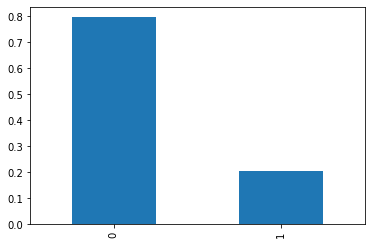

In [15]:
# class balance check
# study the target feature on the training set:
class_frequency_train = target_train.value_counts(normalize=True)
print(class_frequency_train)
class_frequency_train.plot(kind='bar')


0    0.7965
1    0.2035
Name: exited, dtype: float64


<AxesSubplot:>

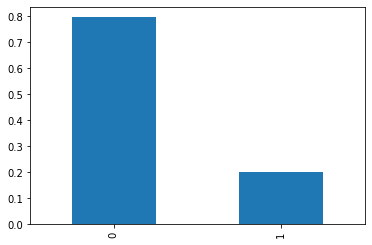

In [16]:
# study the target feature on the validation sample:
class_frequency_valid = target_valid.value_counts(normalize=True)
print(class_frequency_valid)
class_frequency_valid.plot(kind='bar')

The class balance has been checked. It has been established that the training and validation samples have a noticeable imbalance of classes. Answers in the "0" category make up about 80%, and answers in the "1" category about 20%. Therefore, it is likely to expect that the results of model predictions will tend to one answer.

### Examining models without accounting for imbalance

In [17]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_tree = DecisionTreeClassifier(random_state=12345)
    tree_accuracy = model_tree.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_forest = RandomForestClassifier(random_state=12345, n_estimators = 100)
    forest_accuracy = model_forest.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_lgr = LogisticRegression(random_state=12345,solver = 'liblinear')
    accuracy_lgr = model_lgr.fit(features_train, target_train).score(features_valid, target_valid)
    print('Percentage of correct answers:')
    print('decision tree', tree_accuracy)   
    print('random forest', forest_accuracy)
    print('logistic regression', accuracy_lgr)    



In [18]:
all_models_accuracy(features_train_transform, target_train, features_valid_transform, target_valid)

Percentage of correct answers:
decision tree 0.782
random forest 0.862
logistic regression 0.787


In [19]:
#create a constant model that predicts the class 0 for any object (since this value occurs in 80% of cases):
target_pred_constant = pd.Series([0]*len(target_valid))
print('Accuracy constant model =', accuracy_score(target_valid,target_pred_constant))

Accuracy constant model = 0.7965


In [20]:
#get the error matrix for the decision tree:

model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train_transform, target_train)
prediction_tree = model_tree.predict(features_valid_transform)

probabilities_tree_valid = model_tree.predict_proba(features_valid_transform)
probabilities_tree_one_valid = probabilities_tree_valid[:, 1]

confusion_matrix(target_valid, prediction_tree)


array([[1363,  230],
       [ 206,  201]])

In [21]:
#get the error matrix for the random forest:

model_forest = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_forest.fit(features_train_transform, target_train)
prediction_forest = model_forest.predict(features_valid_transform)

probabilities_forest_valid = model_forest.predict_proba(features_valid_transform)
probabilities_forest_one_valid = probabilities_forest_valid[:, 1]

confusion_matrix(target_valid, prediction_forest)

array([[1529,   64],
       [ 212,  195]])

In [22]:
#get the error matrix for logistic regression:
model_lgr = LogisticRegression(random_state=12345, solver = 'liblinear')
model_lgr.fit(features_train_transform, target_train)
prediction_lgr = model_lgr.predict(features_valid_transform)


probabilities_lgr_valid = model_lgr.predict_proba(features_valid_transform)
probabilities_lgr_one_valid = probabilities_lgr_valid[:, 1]

confusion_matrix(target_valid, prediction_lgr)

array([[1539,   54],
       [ 372,   35]])

In [23]:
# write a function to calculate  F1 и "AUC-ROC" metrics:
def rec_metrics(target_valid, prediction, probabilities_one_valid):
    print("F1-measure", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, probabilities_one_valid))
  

In [24]:
#call the function for calculating metrics for the decision tree:
print('Decision tree model')
rec_metrics(target_valid, prediction_tree, probabilities_tree_one_valid)


Decision tree model
F1-measure 0.4797136038186157
AUC-ROC 0.6747379120260476


In [25]:
#call the function for calculating metrics for a random forest:
print('Random forest model')
rec_metrics(target_valid, prediction_forest,  probabilities_forest_one_valid)

Random forest model
F1-measure 0.5855855855855857
AUC-ROC 0.8589868759360285


In [26]:
#call the function for calculating metrics for logistic regression:
print('Logistic Regression Model')
rec_metrics(target_valid, prediction_lgr, probabilities_lgr_one_valid)


Logistic Regression Model
F1-measure 0.14112903225806453
AUC-ROC 0.7731012985250274


Conclusion from the study of the task:
- Models are built using decision tree, random forest and logistic regression algorithms without imbalance. The random forest model showed the highest value of the accuracy metric 0,86.
- A constant model has been built that predicts a class for any object 0. 
the value of the accuracy metric obtained only using the random forest model 0.86 slightly exceeds the value of the accuracy of the constant model 0.80. 

However, because there is a significant imbalance of classes in the samples, the accuracy metric (the proportion of correct answers) could be more suitable, and it is necessary to check the quality of the models using other metrics.
- For a visual representation of the results of calculating the accuracy and recall metrics, error matrices were constructed for each model. It was found that all models tend to give more negative predictions, the number of false negative predictions (FN) exceeds the number of false positives (FP).
- AUC-ROC and F1-measure calculated for each model.
In a decision tree model: the metric F1 = 0,48 and AUC-ROC =0.67  indicates the low quality of the model.
In a random forest model: the metric F1 = 0,59 и AUC-ROC =0.86 slightly higher than the decision tree model, but also far from unity, so the quality of the model is also low.
In a logistic regression model: metric F1 =0,14 и UC-ROC =0.77 - the quality of the model is even lower than in previous models. 
Thus, the obtained estimates of the quality of models on unbalanced data show unsatisfactory results.



## Struggling with imbalance

In [27]:
# to combat the imbalance, we apply the techniques of increasing and decreasing the training set:

def upsample(features, target,repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled    

1    0.505947
0    0.494053
Name: exited, dtype: float64


<AxesSubplot:>

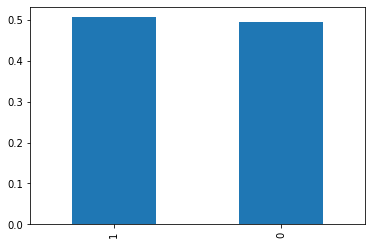

In [28]:
features_train_upsampled, target_train_upsampled = upsample(features_train_transform, target_train.reset_index(drop=True), 4)
print(target_train_upsampled.value_counts(normalize = 1))


class_frequency_upsampled = target_train_upsampled.value_counts(normalize=True)
class_frequency_upsampled.plot(kind='bar')

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

1    0.505999
0    0.494001
Name: exited, dtype: float64
(2417,)


<AxesSubplot:>

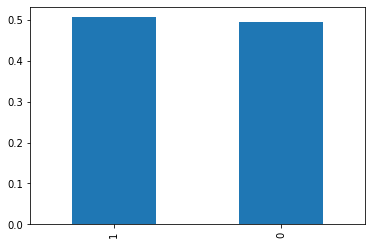

In [30]:
features_train_downsampled, target_train_downsampled = downsample(features_train_transform, target_train.reset_index(drop=True), 0.25)
print(target_train_downsampled.value_counts(normalize = 1))
print(target_train_downsampled.shape)

class_frequency_downsampled = target_train_downsampled.value_counts(normalize=True)
class_frequency_downsampled.plot(kind='bar')

In [31]:
#проверим качество предсказаний моделей на сбалансированной выборке: 

#решающее дерево на увеличенной  выборке: 
 
model_tree_upsampled = DecisionTreeClassifier(random_state=12345)
model_tree_upsampled.fit(features_train_upsampled, target_train_upsampled)
prediction_tree_upsampled = model_tree_upsampled.predict(features_valid_transform)

probabilities_tree_upsampled = model_tree_upsampled.predict_proba(features_valid_transform)
probabilities_tree_one_upsampled = probabilities_tree_upsampled[:, 1]

#решающее дерево на уменьшенной выборке: 
model_tree_downsampled = DecisionTreeClassifier(random_state=12345)
model_tree_downsampled.fit(features_train_downsampled, target_train_downsampled)
prediction_tree_downsampled = model_tree_downsampled.predict(features_valid_transform)

probabilities_tree_downsampled = model_tree_downsampled.predict_proba(features_valid_transform)
probabilities_tree_one_downsampled = probabilities_tree_downsampled[:, 1]

display('Качество решающего дерева на увеличенной выборке')
rec_metrics(target_valid, prediction_tree_downsampled, probabilities_tree_one_downsampled)

display('Качество решающего дерева на уменьшенной выборке')
rec_metrics(target_valid, prediction_tree_upsampled, probabilities_tree_one_upsampled)

# логистическая регрессия на увеличенной  выборке:
model_lgr_upsampled = LogisticRegression(random_state=12345, solver = 'liblinear')
model_lgr_upsampled.fit(features_train_upsampled, target_train_upsampled)
prediction_lgr_upsampled = model_lgr_upsampled.predict(features_valid_transform)

probabilities_lgr_upsampled = model_lgr_upsampled.predict_proba(features_valid_transform)
probabilities_lgr_one_upsampled = probabilities_lgr_upsampled[:, 1]

# логистическая регрессия на уменьшенной выборке:
model_lgr_downsampled = LogisticRegression(random_state=12345, solver = 'liblinear')
model_lgr_downsampled.fit(features_train_downsampled, target_train_downsampled)
prediction_lgr_downsampled = model_lgr_downsampled.predict(features_valid_transform)

probabilities_lgr_downsampled = model_lgr_downsampled.predict_proba(features_valid_transform)
probabilities_lgr_one_downsampled = probabilities_lgr_downsampled[:, 1]

display('Качество логистической регрессии на увеличенной выборке')
rec_metrics(target_valid, prediction_lgr_upsampled, probabilities_lgr_one_upsampled)

display('Качество логистической регрессии на уменьшенной выборке')
rec_metrics(target_valid, prediction_lgr_downsampled, probabilities_lgr_one_downsampled)


# случайный лес на увеличенной  выборке:
model_forest_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_forest_upsampled.fit(features_train_upsampled, target_train_upsampled)
prediction_forest_upsampled = model_forest_upsampled.predict(features_valid_transform)

probabilities_forest_upsampled = model_forest_upsampled.predict_proba(features_valid_transform)
probabilities_forest_one_upsampled = probabilities_forest_upsampled[:, 1]

#случайный лес на уменьшенной  выборке:

model_forest_downsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_forest_downsampled.fit(features_train_downsampled, target_train_downsampled)
prediction_forest_downsampled = model_forest_downsampled.predict(features_valid_transform)

probabilities_forest_downsampled = model_forest_downsampled.predict_proba(features_valid_transform)
probabilities_forest_one_downsampled = probabilities_forest_downsampled[:, 1]

display('Качество случайного леса на увеличенной выборке')
rec_metrics(target_valid, prediction_forest_upsampled, probabilities_forest_one_upsampled)

display('качество случайного леса на уменьшенной выборке')
rec_metrics(target_valid, prediction_forest_downsampled,probabilities_forest_one_downsampled)


'Качество решающего дерева на увеличенной выборке'

F1-мера 0.49315068493150677
AUC-ROC 0.7053463324649766


'Качество решающего дерева на уменьшенной выборке'

F1-мера 0.47440699126092384
AUC-ROC 0.6693851015884914


'Качество логистической регрессии на увеличенной выборке'

F1-мера 0.497883149872989
AUC-ROC 0.7770975906569126


'Качество логистической регрессии на уменьшенной выборке'

F1-мера 0.5029940119760479
AUC-ROC 0.7758991657296741


'Качество случайного леса на увеличенной выборке'

F1-мера 0.5932642487046632
AUC-ROC 0.85326929394726


'качество случайного леса на уменьшенной выборке'

F1-мера 0.5853658536585366
AUC-ROC 0.8566663736155261


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
На каждом этапе анализа (при любом методе борьбы с дисбалансом или при его отсутствии) должны быть исследованы все выбранные модели.

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
Исследованы три модели на сбалансированной выборке, внесены изменения в вывод по разделу и в общий вывод.
</div> 
<br/>    
    

<div class="alert alert-success">
<h2> Комментарий ревьюера №2<a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    


In [32]:
#так как случайный лес показывает лучшие показатели метрики F1 на увеличенной выборке,
#подберем лучшие гиперпараметры для увеличения метрики F1:

forest_best_result = 0
forest_best_depth = 0
forest_best_est = 0

for est in range (10,200, 10):
    for depth in range (10,30,2):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train_upsampled, target_train_upsampled)
        predictions_forest_valid = model_forest.predict(features_valid_transform)
        
        probabilities_forest_best = model_forest.predict_proba(features_valid_transform)
        probabilities_forest_one_best = probabilities_forest_best[:, 1]

        result_forest = f1_score(target_valid, predictions_forest_valid)
        
        if result_forest > forest_best_result:
            forest_best_result = result_forest
            forest_best_depth = depth
            forest_best_est = est
        
print('Лучшая модель на валидационной выборке с помощью случайного леса с лучшим количеством деревьев =', forest_best_est, 'и лучшей глубиной', forest_best_depth)
print('F1-мера = :', forest_best_result) 
print("AUC-ROC", roc_auc_score(target_valid, probabilities_forest_one_best))
       




Лучшая модель на валидационной выборке с помощью случайного леса с лучшим количеством деревьев = 120 и лучшей глубиной 14
F1-мера = : 0.6233766233766234
AUC-ROC 0.8567003058528483


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
    
Молодец, что подбираешь гиперпараметры.

Выводы:
Для борьбы с дисбалансом использованы техники увеличения и уменьшения тренировочной выборки. По результатам применения обеих техник получено практически равное соотношение объектов класса 0 и 1 (0.505947 к 0.494001). На  полученных сбалансированных выборках проведена проверка качества предсказаний ирех моделей. Лучшее значение меры F1 получено при использовании модели случайного леса на увеличенной сбалансированной выборке. Для улучшения показателей качества, полученных с помощью  модели случайного леса, проведен подбор оптимальных значений гиперпараметров 'глубина деревьев' и 'количество деревьев'. В результате  показатель F1-меры=0.623  и AUC-ROC= 0,856 получен при лучшей глубине 14  c количеством деревьев 120. 


## Тестирование модели

In [33]:
# проверим модель, полученную на валидационной выборке с помощью случайного леса с лучшими гиперпараметрами на тестовой выборке:

model_test = RandomForestClassifier(random_state=12345, n_estimators=120, max_depth=14)
model_test.fit(features_train_upsampled, target_train_upsampled)
prediction_test = model_test.predict(features_test_transform)

probabilities_test = model_test.predict_proba(features_test_transform)
probabilities_test_one = probabilities_test[:, 1]

rec_metrics(target_test, prediction_test,probabilities_test_one )

          


F1-мера 0.5919811320754718
AUC-ROC 0.8510220544118849


Полученная F1-мера лучшей модели на тестовой выборке равна 0,592 и удовлетворяет требуемому значению. При этом метрика AUC-ROC  равна 0.85, что выше значения случайной модели.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
А тестировать нужно только лучшую модель, это так.

## Вывод

1. По результатам проверки качества исходных данных выполнено следующее:
- названия столбцов приведены к нижнему регистру
- названия столбцов приведены к  змеиному стилю
- проведена проверка на пропуски. Пропуски обнаружены только в столбце tunure в количестве 909 (9% от общего числа выборки). В связи с тем, что доля пропусков значительная, удалять данные строки не следует, поэтому пропуски  заменены на медианное значение 
- проведена проверка на наличие явных дубликатов: явных дубликатов не выявлено
- столбец geography  содержит всего три уникальных значения: France', 'Spain', 'Germany'
- удалены 3 столбца-идентификаторов, не представляющих  ценность для дальнейшего анализа: row_number,customer_id, surname
- проверка на мультиколлинеарность показала низкую корреляцию между независящими параметрами.

Целевой признак exited (факт ухода клиента) принимает только два значения (0 и 1) и является категориальным признаком, таким образом, задача должна решаться методами классификации.

2. В результате подготовки данных для машинного обучения выполнено следующее:
- откорректированный набор исходных данных разбит на три отдельных выборки: тренировочную, валидационную и тестовую. Размер тренировочной выборки составил 6000 строк, валидационной и тестовой по 2000 строк.
- к полученным выборкам применены 2 техники для обработки числовых и категориальных признаков. При помощи техники OneHotEncoder категориальные признаки 'geography', 'gender' преобразованы в численные значения. При помощи техники стандартизации данных  StandardScaler численные признаки приведены к одному масштабу.
- чтобы избежать дамми-ловушки, удалены 2 столбца при обработки категориальных значений ('France' и 'Female')

3. В ходе исследования задачи выполнено следующее:
- построены модели с помощью алгоритмов решающего дерева, случайного леса и логистической регрессии без учета дисбаланса. Самое высокое значение метрики accuracy показала модель случайного леса (0,86).
- построена константная модель, которая любому объекту прогнозирует класс «0» (так как это значение встречается 80% случаев).
Значение метрики accuracy полученное только с помощью модели случайного леса (0.86) несколько превышает значение accuracy константной модели (0.80). Однако ввиду того, что в выборках наблюдается значительный дисбаланс классов, метрика accuracy (доля правильных ответов) не подходит и нужно проверить качество моделей, используя другие метрики.
- для наглядного представления результатов вычислений метрик точности и полноты построены матрицы ошибок для каждой модели. Установлено, что все модели склонны выдавать больше негативные предсказания, количество ложных негативных предсказаний (FN) превышает количество ложных позитивных (FP).
- Для каждой модели рассчитаны  F1-мера и AUC-ROC.
В модели решающего дерева: метрика F1 = 0,48 и AUC-ROC =0.67 и свидетельствует  о невысоком качестве модели.
В модели случайного леса: метрика F1 = 0,59 и AUC-ROC =0.86 несколько выше, чем у модели решающего дерева, но также далеко от единицы, поэтому качество модели также низкое.
В модели логистической регрессии: метрика F1 =0,14 и UC-ROC =0.77 - качество модели еще ниже, чем в предыдущих моделях. 
Таким образом, полученные оценки качества моделей на несбалансированных данных показывают неудовлетворительные результаты.


4. Для борьбы с дисбалансом использованы техники увеличения и уменьшения тренировочной выборки. По результатам применения обеих техник получено практически равное соотношение объектов класса 0 и 1 (0.505947 к 0.494001). На  полученных сбалансированных выборках проведена проверка качества предсказаний трех моделей. Лучшее значение меры F1 получено при использовании модели случайного леса на увеличенной сбалансированной выборке. Для улучшения показателей качества, полученных с помощью  модели случайного леса, проведен подбор оптимальных значений гиперпараметров 'глубина деревьев' и 'количество деревьев'. В результате  показатель F1-меры=0.623  и AUC-ROC= 0,856 получен при лучшей глубине 14  c количеством деревьев 120. 

5. По результатам тестирования лучшей модели на тестовой выборке удалось достигнуть значение метрики F1 0.592, что удовлетворяет уловию решения задачи, при этом AUC-ROC равно 0.85, что выше значения случайной модели.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Какой подробный резюмирующий вывод. Молодец.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь я оставлю некоторые интересные ссылки и материалы по теме:
        
1. "Metrics and scoring: quantifying the quality of predictions"
        
https://scikit-learn.org/stable/modules/model_evaluation.html
        
2. "When to use One Hot Encoding vs LabelEncoder vs DictVectorizor?"
        
https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
        
3. "Как делать кросс-валидацию при апсемплинге данных"
        
https://datascience.xyz/practice/kak-delat-kross-validaciju-pri-apsemplinge-dannyh.html
        
4. "Масштабирование, стандартизация или нормализация с помощью Scikit-Learn"
        
https://datascience.xyz/theory/masshtabirovanie-standartizaciya-ili-normalizaciya-s-pomoshhju-scikit-learn.html
        
5. "Ordinal and One-Hot Encodings for Categorical Data"
        
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
        

<div style="border:solid Chocolate 2px; padding: 40px">
    
<b>Общий вывод по проекту</b>

Анастасия, благодарю тебя за работу! 
    Проект отличный, аккуратный, продуманный. Есть места в проекте, которые требуют твоего внимания.

**Положительные моменты проекта, которые хочу еще раз подчеркнуть**:

    1. Выдержана структура проекта,
    2. Проведена предварительная работа с данными
    3. Метрика F1 score показывает хороший результат
    4. Использовано 2 метода работы с несбалансированными данными
    5. Есть анализ работы моделей без учета дисбаланса
    6. Есть промежуточные и итоговый выводы
    7. Аккуратность кода на высоком уровне
   

**Замечания, на которые стоит обратить внимание при будущей работе**:
    
    1. Стоит провести для всех исследуемых моделей этапы работы с дисбалансом.
    
Остальные комментарии ты найдешь выше.
    
**Желаю удачи и жду твой проект на повторное ревью!**

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
Ксения, спасибо за рекомендации и полезные ссылки. Уверена, что этот материал будет полезен при выподнении последующих проектов.
</div> 
<br/>  

<div style="border:solid Chocolate 2px; padding: 40px">
    
<b>Общий вывод по проекту №2</b>

Анастасия, благодарю тебя за работу!
    
**Все хорошо, проект принимаю и желаю успехов в дальнейшей учебе!**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*